[link dataset](https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k)

# Setup

### command line

In [ ]:
# import the kaggle.json from kaggle API into colab
# do this command

# install kaggle library
!pip install kaggle
# make a directory named .kaggle
!mkdir ~/.kaggle
# copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/
# alocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json
# download dataset
!kaggle datasets download doctrinek/oxford-iiit-cats-extended-10k

 99% 987M/993M [00:12<00:00, 99.5MB/s]
100% 993M/993M [00:12<00:00, 82.9MB/s]


In [ ]:
!pip install -q split-folders

### import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib, zipfile, os, splitfolders, datetime

### extract zip file

In [ ]:
zip_path = "/content/oxford-iiit-cats-extended-10k.zip"
zip_read = zipfile.ZipFile(zip_path, "r")
zip_read.extractall('/content/dataset')
zip_read.close()

In [ ]:
os.listdir('/content/dataset/')

['CatBreedsRefined-v3']

In [ ]:
original_dir = '/content/dataset/CatBreedsRefined-v3'

### split into train and validation

In [ ]:
splitfolders.ratio(original_dir, output='/content/project', seed=6969, ratio=(0.8, 0.2))
train_dir = '/content/project/train'
validation_dir = '/content/project/val'

Copying files: 10257 files [00:07, 1284.62 files/s]


### explore data samples

In [ ]:
def total_sample(directory):
  total = 0
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    total += len(os.listdir(folder_path))

  return total

train_sample_length = total_sample(train_dir)
validation_sample_length = total_sample(validation_dir)
print(f"The train directory has {train_sample_length} samples")
print(f"The validation directory has {validation_sample_length} samples")
print(f"Which in total makes it {train_sample_length + validation_sample_length} samples")

The train directory has 8202 samples
The validation directory has 2055 samples
Which in total makes it 10257 samples


### display images

In [ ]:
def display_image(path, num_images=3, subplot_size=(10,5)):
  files = os.listdir(path)

  fig, axes = plt.subplots(1, num_images, figsize=subplot_size)

  for i in range(min(num_images, len(files))):
    file_path = os.path.join(path, files[i])

    img = mpimg.imread(file_path)
    axes[i].imshow(img)
    axes[i].set_title(f"image {i+1}")
    axes[i].axis('off')

  plt.suptitle(f"Images from {path}")
  plt.show()

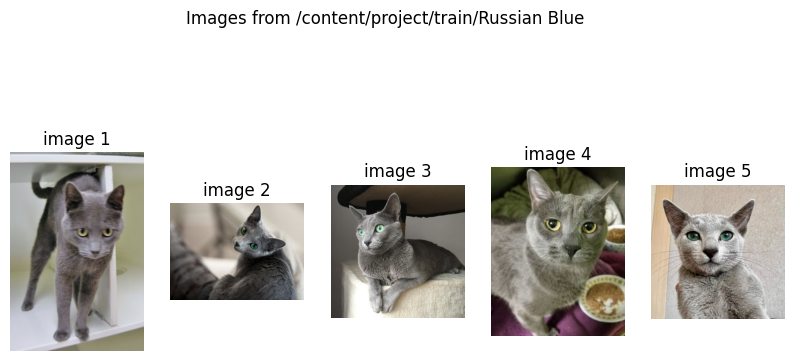

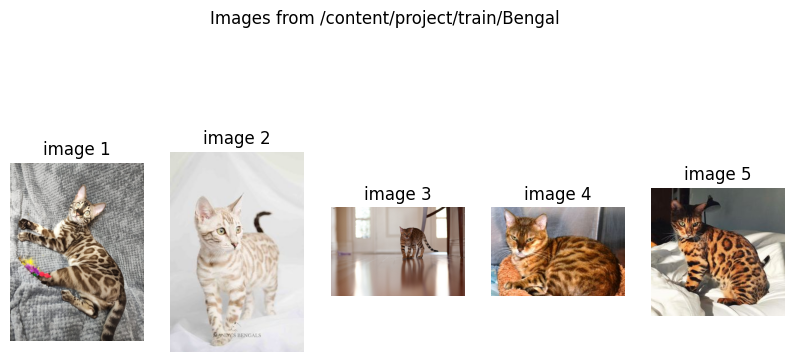

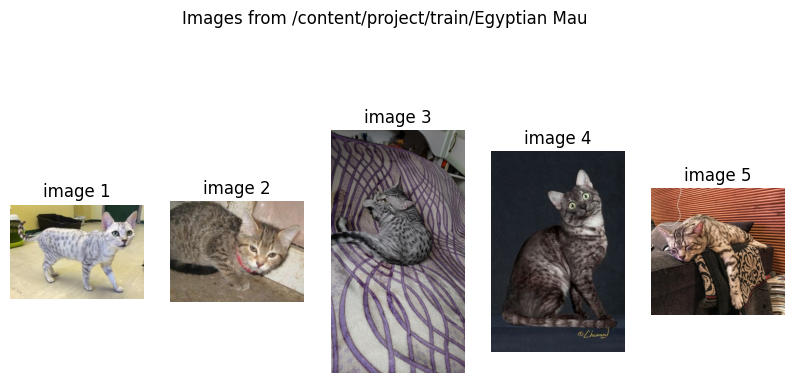

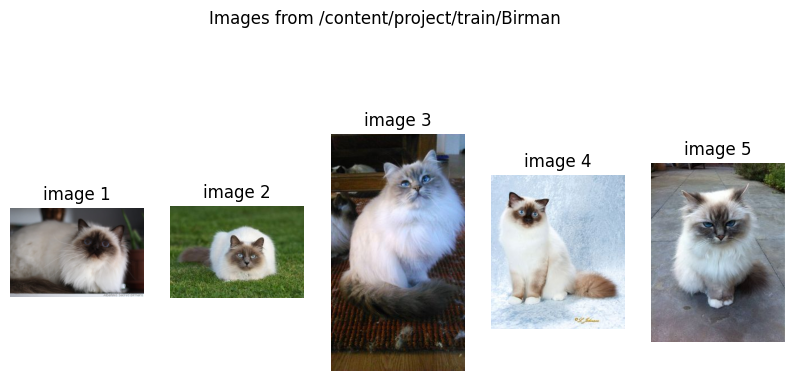

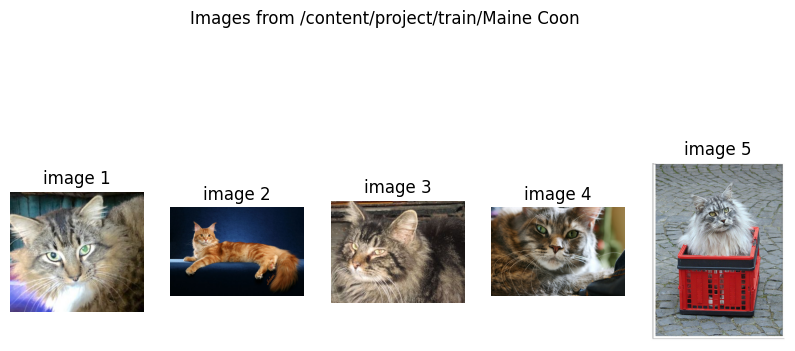

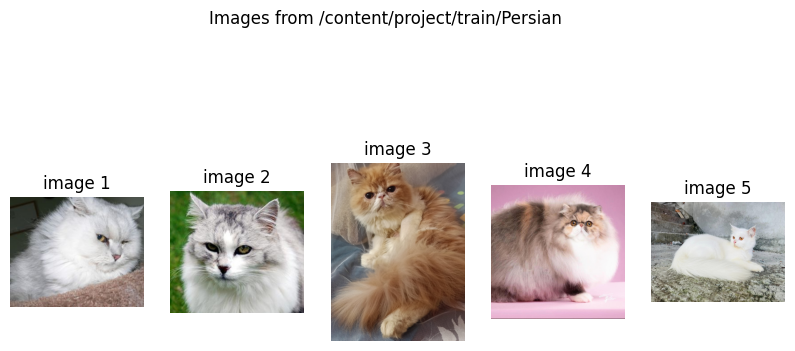

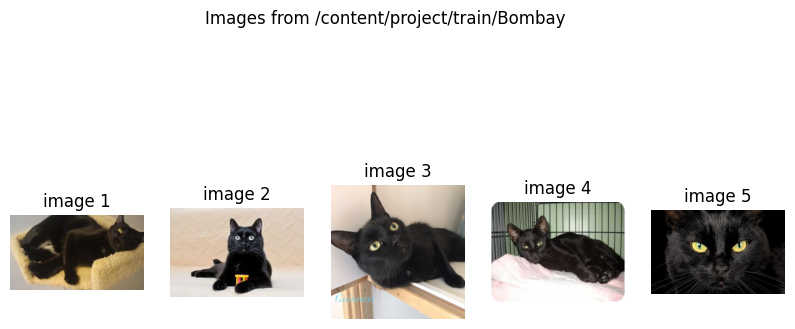

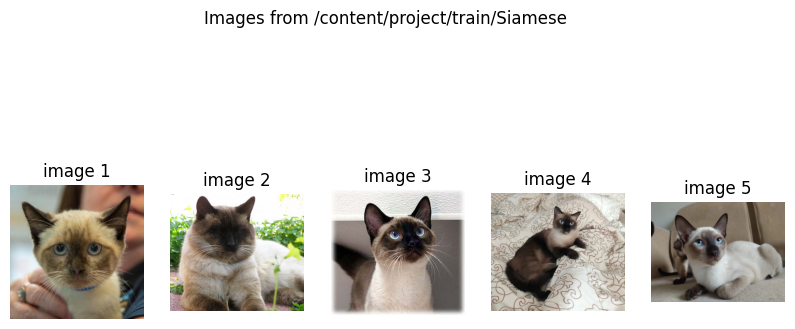

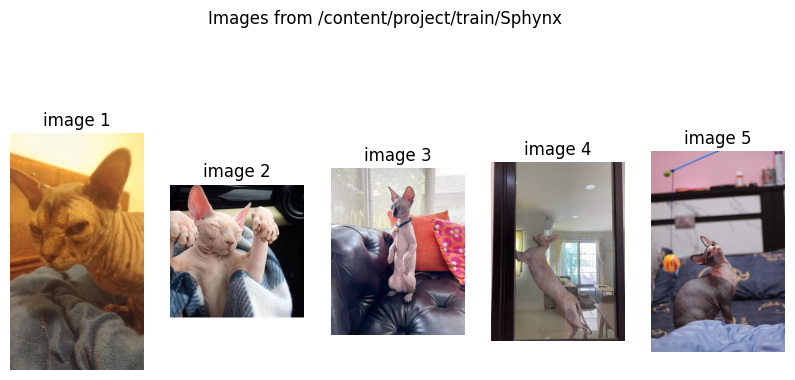

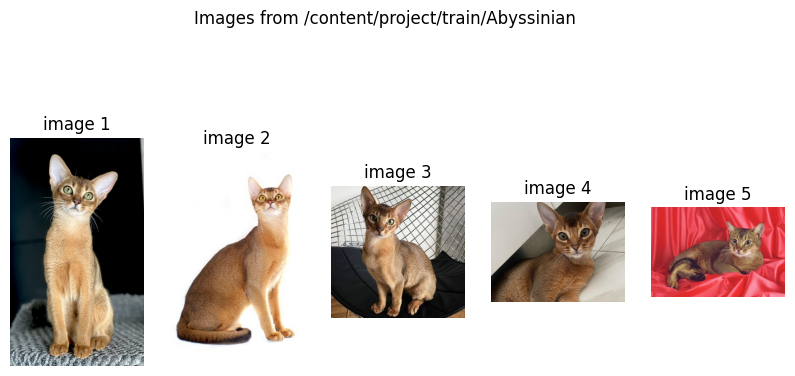

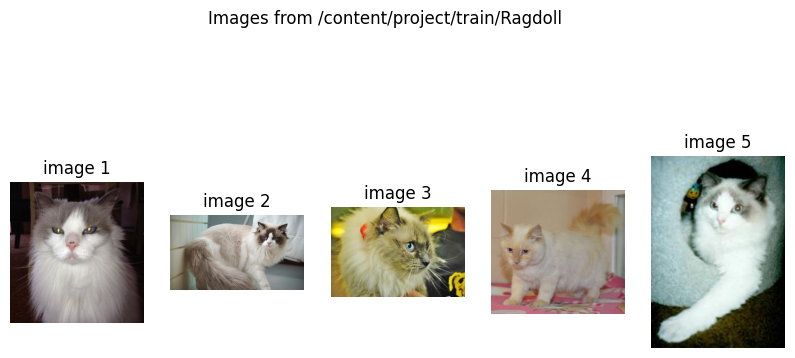

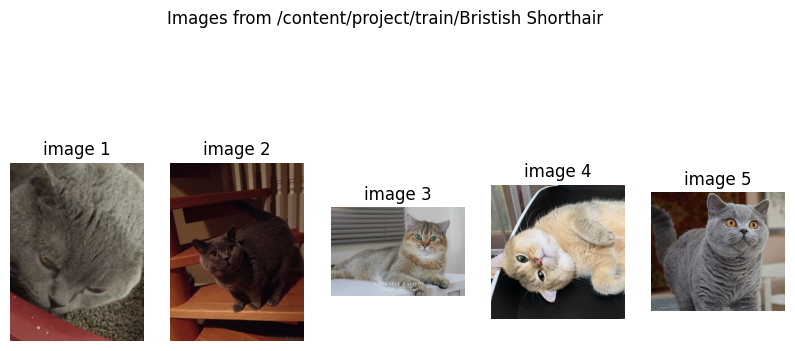

In [ ]:
folder_path = [f.path for f in os.scandir(train_dir) if f.is_dir()]

for path in folder_path:
  display_image(path, num_images=5)

# Preprocess Data
```
rescale = 1.0/255,
shear_range=0.2,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
channel_shift_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
```

In [ ]:
batch_size = 50
target_size=(224,224)
steps_per_epoch = train_sample_length / batch_size
validation_step = validation_sample_length / batch_size
rescale_factor = 1.0 / 255

train_datagen = ImageDataGenerator(
    rescale = rescale_factor,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(
    rescale=rescale_factor
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size
)

Found 8202 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.


# Model Creation

### callback function
- stops when acc & val_acc is >= 92%
- stops when acc / val_acc < max_acc for limit_acc epochs
- stops when loss / val_loss > 0.75 for limit_loss epochs


In [ ]:
class SantaiDuluGakSih(tf.keras.callbacks.Callback):
  def __init__(self, sabar_acc=10, sabar_loss=10):
    super(SantaiDuluGakSih, self).__init__()
    self.sabar_acc = sabar_acc
    self.sabar_loss = sabar_loss
    self.limit_acc = sabar_acc
    self.limit_loss = sabar_loss
    self.max_acc = 0
    self.max_val_acc = 0

  def on_epoch_end(self, epoch, logs={}):
    self.max_acc = logs.get('accuracy') if logs.get('accuracy') > self.max_acc else self.max_acc

    self.max_val_acc = logs.get('val_accuracy') if logs.get('val_accuracy') > self.max_val_acc else self.max_val_acc

    if logs.get('accuracy')>=self.max_acc and logs.get('val_accuracy')>=self.max_val_acc:
      self.sabar_acc = self.limit_acc
    else:
      self.sabar_acc -= 1

    if logs.get('loss')>0.75 or logs.get('val_loss')>0.75:
      self.sabar_loss -= 1
    else:
      self.sabar_loss += self.limit_loss

    if self.sabar_acc == 0:
      print(f"The model accuracy has been below {self.max_acc} and {self.max_val_acc} for {self.limit_acc} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True
    elif self.sabar_loss == 0:
      print(f"The model loss has been above 75% for {self.limit_loss} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True
    elif logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
      print(f"The model accuracy has reached 92%, stopping training")
      self.model.stop_training = True

In [ ]:
class learningrateLogger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Epoch {epoch+1}/{self.params['epochs']}, Learning Rate: {self.model.optimizer.lr.numpy()}")

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.8,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001
)

### transfer learning using MobileNetV2

In [ ]:
model = tf.keras.Sequential()

# add mobile net as base layer
pre_trained_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in pre_trained_model.layers:
  layer.trainable = True

print("Jumlah layer di pre_trained_model: ", len(pre_trained_model.layers))

fine_tune_di = 120

for layer in pre_trained_model.layers[:fine_tune_di]:
  layer.trainable = False

print("trainable layer: ", len(pre_trained_model.trainable_variables))

model.add(pre_trained_model)

9406464/9406464 [==============================] - 0s 0us/step
Jumlah layer di pre_trained_model:  154
trainable layer:  36


In [ ]:
# add custom layers
do = 0.4
l2val = 0.0001
model.add(Dropout(do))
model.add(Conv2D(64, (3,3), activation="relu", input_shape=(224,224,3), kernel_regularizer=l2(l2val)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(do))
model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2val)))
model.add(Dropout(do))
model.add(Dense(64, activation="relu"))
model.add(Dropout(do))
model.add(Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 64)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0

In [ ]:
int_lr = 1e-4
model.compile(
    optimizer=tf.optimizers.Adam(int_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
loss0, acc0 = model.evaluate(validation_generator)

42/42 [==============================] - 22s 377ms/step - loss: 3.6844 - accuracy: 0.0813


In [ ]:
berhenti_bang = SantaiDuluGakSih(sabar_acc=5, sabar_loss=10)
modelku = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_step,
    validation_data=validation_generator,
    callbacks=[berhenti_bang, reduce_lr, learningrateLogger()],
    verbose=2
)

Epoch 1/30
Epoch 1/30, Learning Rate: 9.999999747378752e-05
164/164 - 169s - loss: 0.8728 - accuracy: 0.7430 - val_loss: 0.5646 - val_accuracy: 0.8355 - lr: 1.0000e-04 - 169s/epoch - 1s/step
Epoch 2/30
Epoch 2/30, Learning Rate: 9.999999747378752e-05
164/164 - 160s - loss: 0.8179 - accuracy: 0.7643 - val_loss: 0.5061 - val_accuracy: 0.8574 - lr: 1.0000e-04 - 160s/epoch - 973ms/step
Epoch 3/30
Epoch 3/30, Learning Rate: 9.999999747378752e-05
164/164 - 168s - loss: 0.7389 - accuracy: 0.7885 - val_loss: 0.4776 - val_accuracy: 0.8686 - lr: 1.0000e-04 - 168s/epoch - 1s/step
Epoch 4/30
Epoch 4/30, Learning Rate: 9.999999747378752e-05
164/164 - 161s - loss: 0.7092 - accuracy: 0.8010 - val_loss: 0.5503 - val_accuracy: 0.8506 - lr: 1.0000e-04 - 161s/epoch - 980ms/step
Epoch 5/30

Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
Epoch 5/30, Learning Rate: 7.999999797903001e-05
164/164 - 165s - loss: 0.6809 - accuracy: 0.8136 - val_loss: 0.5401 - val_accuracy: 0.8584 - 

# Model evaluation

### plot loss and accuracy

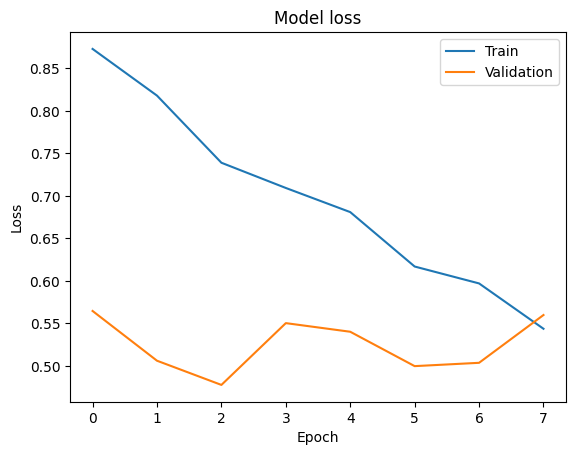

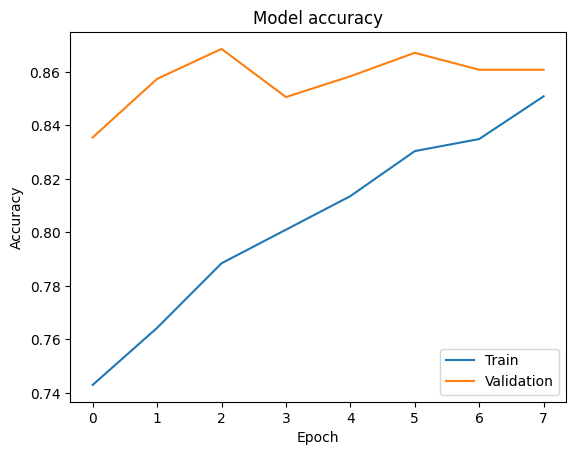

In [ ]:
# plot loss
plt.plot(modelku.history['loss'])
plt.plot(modelku.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot acc
plt.plot(modelku.history['accuracy'])
plt.plot(modelku.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
val_loss_acc = model.evaluate(validation_generator, steps=len(validation_generator))

42/42 [==============================] - 15s 358ms/step - loss: 0.5598 - accuracy: 0.8608


Saving Abyssinian_10.jpg to Abyssinian_10.jpg
Saving Bristish Shorthair_1.jpg to Bristish Shorthair_1.jpg
Saving Russian Blue_10.jpg to Russian Blue_10.jpg


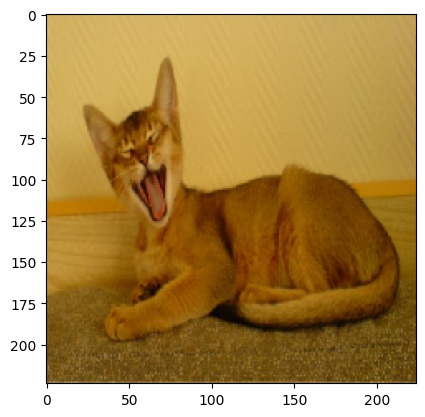

1/1 [==============================] - 2s 2s/step
Predicted Class: Egyptian Mau
Confidence Score: 0.09957761317491531


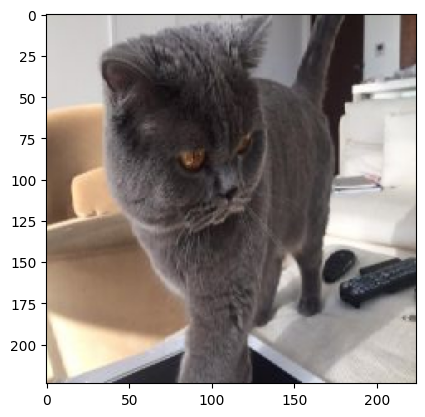

1/1 [==============================] - 0s 23ms/step
Predicted Class: British Shorthair
Confidence Score: 0.0907367616891861


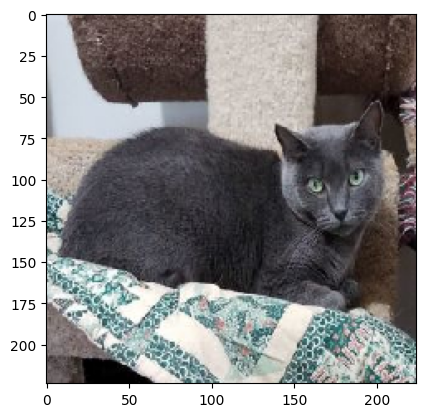

1/1 [==============================] - 0s 22ms/step
Predicted Class: British Shorthair
Confidence Score: 0.09094052761793137


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau',
                'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']

for fn in uploaded.keys():

  #predict gambar
  path = fn
  img = image.load_img(path, target_size=target_size)

  imgplot = plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  confidence_score = classes[0][predicted_index]

  predicted_label = class_labels[predicted_index]

  print(f"Predicted Class: {predicted_label}")
  print(f"Confidence Score: {confidence_score}")

# Save model

In [ ]:
# menyimpan model dalam format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

11984736